# RNN :Industrial Production Data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

In [2]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
#CODE HERE

In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


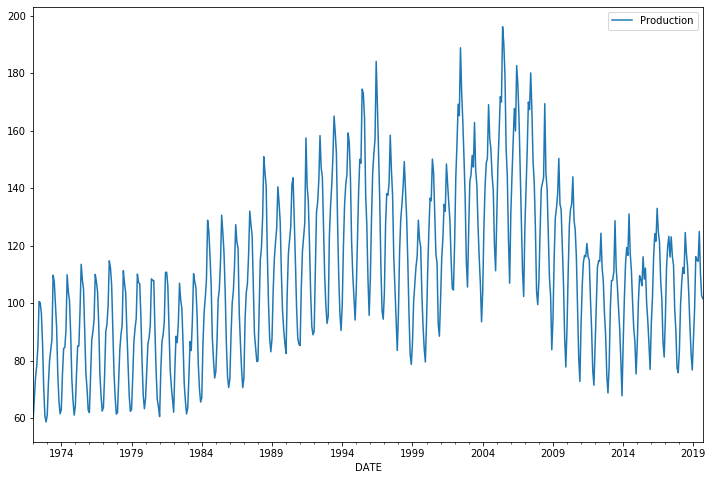

In [7]:
df.plot(figsize=(12,8))

## Train Test Split

In [8]:
len(df)

573

In [9]:
test_size = 24
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
len(test)

24

## Scale Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator


In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [20]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 531 steps, validate for 6 steps
Epoch 1/20
531/531 [==============================] - 10s 19ms/step - loss: 0.0312 - val_loss: 0.0066
Epoch 2/20
531/531 [==============================] - 9s 16ms/step - loss: 0.0161 - val_loss: 0.0052
Epoch 3/20
531/531 [==============================] - 9s 16ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 4/20
531/531 [==============================] - 9s 16ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 5/20
531/531 [==============================] - 9s 16ms/step - loss: 0.0035 - val_loss: 0.0025


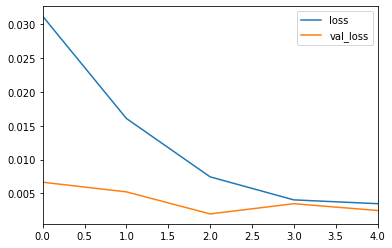

In [26]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Evaluate on Test Data

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

C:\Users\Yasser B\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,94.201538
2017-11-01,77.4378,87.172365
2017-12-01,75.8118,84.933961
2018-01-01,83.4343,92.716209
2018-02-01,99.4899,102.841791
2018-03-01,107.3152,111.736724
2018-04-01,112.4309,118.707000
2018-05-01,110.3544,122.861334
2018-06-01,124.5841,122.867899


**Predictions versus the True test values.**

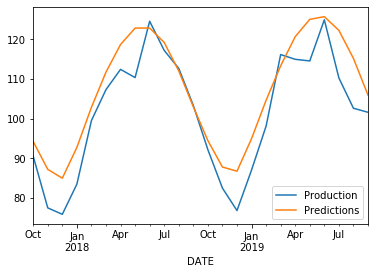

In [31]:
test.plot()

**RMSE.**

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

7.14012882244555

# These results can be improved!